In [1]:
import pandas as pd

df = pd.read_csv("sri_lanka_household_dataset_raw.csv")
df.head()

,Household_ID,District,Household_Size,Head_Age,Education_Level,Employment_Status,Monthly_Income_LKR,Food_Expenditure_LKR,NonFood_Expenditure_LKR,Housing_Type,Electricity_Access,Water_Access,Owns_Vehicle,Owns_Computer
0,1,Kurunegala,1,31,Primary,Self-employed,155431,16848,77573,Permanent,Yes,No,Yes,No
1,2,Kandy,7,22,Secondary,Self-employed,144048,86672,98665,Permanent,No,Yes,Yes,Yes
2,3,Anuradhapura,4,64,No Schooling,Self-employed,248269,74125,112803,Temporary,No,No,No,Yes
3,4,Galle,3,37,No Schooling,Self-employed,57056,69602,18386,Semi-permanent,Yes,Yes,Yes,No
4,5,Kurunegala,4,59,Advanced Level,Self-employed,66831,80045,59460,Temporary,Yes,Yes,No,No


In [2]:
poverty_threshold = 60000

df["Poverty_Status"] = df["Monthly_Income_LKR"].apply(
    lambda x: 1 if x < poverty_threshold else 0
)

In [3]:
df["Poverty_Status"].value_counts()

Poverty_Status
0    801
1    199
Name: count, dtype: int64

In [4]:
X = df.drop(["Poverty_Status", "Household_ID"], axis=1)
y = df["Poverty_Status"]

In [5]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

categorical_cols = [
    "District",
    "Education_Level",
    "Employment_Status",
    "Housing_Type",
    "Electricity_Access",
    "Water_Access",
    "Owns_Vehicle",
    "Owns_Computer"
]

numeric_cols = [
    "Household_Size",
    "Head_Age",
    "Monthly_Income_LKR",
    "Food_Expenditure_LKR",
    "NonFood_Expenditure_LKR"
]

from sklearn.impute import SimpleImputer

# For numeric columns, fill missing values with the median
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# For categorical columns, fill missing values with "missing" and then one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="passthrough"
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42
    ))
])

In [7]:
pipeline.fit(X_train_raw, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [8]:
y_pred = pipeline.predict(X_test_raw)

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [10]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



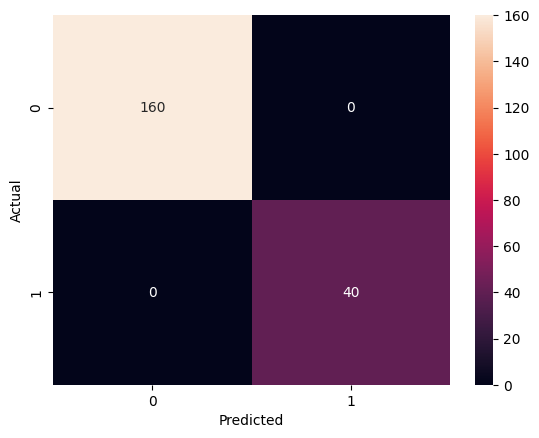

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

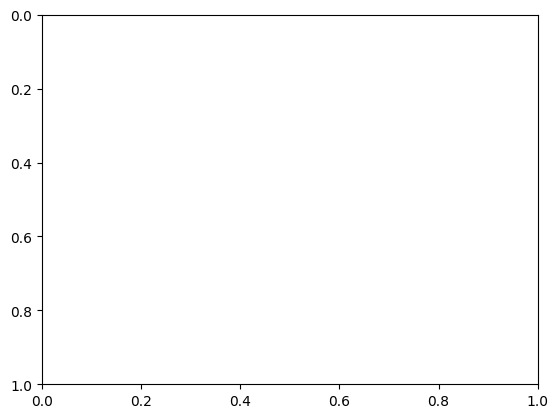

In [12]:
model = pipeline.named_steps["classifier"]
importances = model.feature_importances_
plt.gca().invert_yaxis()
plt.show()

In [13]:
import joblib
joblib.dump(pipeline, "poverty_model.pkl")

['poverty_model.pkl']